In [114]:
# from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [115]:
oracle_frame = pd.read_csv('../data/processed/image_name_label.csv')
oracle_frame.head()

,image,name,label
0,3653610.jpg,安,151
1,3655161.jpg,安,151
2,3655689.jpg,安,151
3,3655818.jpg,八,237
4,3656106.jpg,八,237


In [116]:
label2name_frame = pd.read_csv("../data/processed/label_name.csv")
label2name_frame.head()

,label,name
0,0,子
1,1,合
2,2,酉
3,3,莫
4,4,朿


In [117]:
label2name_frame.shape

(793, 2)

In [118]:
id = np.random.randint(1500)
img_file = oracle_frame.iloc[id, 0]
script_name = oracle_frame.iloc[id, 1]
label = oracle_frame.iloc[id, 2]
print('Image file name: {}'.format(img_file))
print('Chinese Oracle Script: {}'.format(script_name))
print('Script Label / index: {}'.format(label))

Image file name: 4318708.jpg
Chinese Oracle Script: 倗
Script Label / index: 241


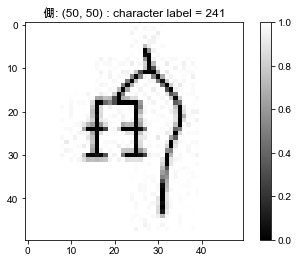

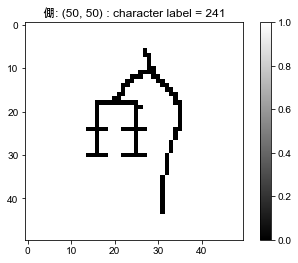

In [119]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

plt.rcParams['font.family'] = 'Arial Unicode MS'

def plotimage(img, script_name, label):
    img = rgb2gray(img)
    # thresh = threshold_otsu(img_gray)
    # img_bin = img_gray > thresh
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plot_title = f"{script_name}: {img.shape} : character label = {label}"
    plt.title(plot_title)
    plt.pause(0.001)
  
def plotimage_after_otsu(img, script_name, label):  
    img_gray = rgb2gray(img)
    thresh = threshold_otsu(img_gray)
    img_bin = img_gray > thresh
    # plt.imshow(img_bin, cmap='gray')
    imgplot = plt.imshow(img_bin, cmap='gray')
    # imgplot.set_cmap('nipy_spectral')
    plt.title(f"{script_name}: {img_bin.shape} : character label = {label}")
    plt.colorbar()
    plt.show()



img = imread(fname='../data/raw/image/' + img_file)

plotimage(img, script_name, label)    

plt.show() 

plotimage_after_otsu(img, script_name, label)    

plt.show() 

In [120]:
 
img.shape

(50, 50, 3)

In [121]:
img_temp = img[:,:,0]
img_temp.shape

(50, 50)

In [122]:
class OracleDataset(Dataset):
    """Oracle dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.oracle_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.oracle_frame)

    def __getitem__(self, idx):
        img_file = os.path.join(self.root_dir,
                                self.oracle_frame.iloc[idx, 0])
        # H,W,C
        img = io.imread(img_file)  
        # img_gray = rgb2gray(img)
        # thresh = threshold_otsu(img_gray)
        # img_bin = img_gray > thresh

        # H, W, 1      
        img = np.expand_dims(img[:, :, 0], axis=2)
        # img = np.expand_dims(img_bin, axis=2)
        
        name = self.oracle_frame.iloc[idx, 1]
        label = self.oracle_frame.iloc[idx, 2]

        sample = {'image': img, 'name': name, 'label': label}            
        if self.transform:
            sample = self.transform(sample)

        return sample

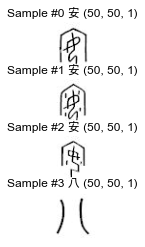

In [123]:
dataset = OracleDataset(csv_file="../data/processed/image_name_label.csv",
                                    root_dir='../data/raw/image/')

fig = plt.figure()
for i in range(len(dataset)):
    sample = dataset[i]
    # print(i, sample['image'].shape, sample['name'], sample['label'])
    ax = plt.subplot(4, 1, i + 1)
    # plt.tight_layout()
    ax.set_title('Sample #{} {} {}'.format(i, sample['name'], sample['image'].shape))
    ax.axis('off')
    img = sample['image']
    # img = rgb2gray(img)
    # thresh = threshold_otsu(img)
    # img = img > thresh
    plt.imshow(img, cmap='gray')
    # plt.pause(0.001)
    if i == 3:
        plt.show()
        break

In [124]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, name, label = sample['image'], sample['name'], sample['label']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'name': name, 'label': label}   


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, name, label = sample['image'], sample['name'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'name': name, 'label': label} 


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, name, label = sample['image'], sample['name'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'name': name,
                'label': torch.tensor(label)}


import torchvision.transforms.functional as TF
import random
import torchvision.transforms as T

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, sample):
        image, name, label = sample['image'], sample['name'], sample['label']
        angle = random.choice(self.angles)

        image = image.astype(np.uint8)

        image = T.ToPILImage()(image)
        image = TF.rotate(image, angle, fill='white')
        # image = T.PILToTensor()(image)
        # image = image.transpose((2, 0, 1))
        # image = T.ToNumpy()(image)

        image = np.array(image)
        image = np.expand_dims(image, axis=2)
        return {'image': image,
                'name': name,
                'label': torch.tensor(label)}


            

(40, 40, 1) <class 'numpy.ndarray'>
(35, 35, 1) <class 'numpy.ndarray'>
(50, 50, 1) <class 'numpy.ndarray'>
(35, 35, 1) <class 'numpy.ndarray'>


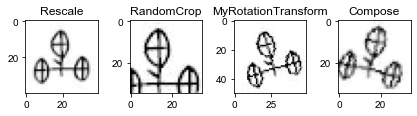

In [125]:
scale = Rescale(40)
crop = RandomCrop(35)
rotation_transform = MyRotationTransform(angles=[-30, -15, 0, 15, 30])    

composed = transforms.Compose([MyRotationTransform(angles=[-30, -15, 0, 15, 30]), Rescale(40), RandomCrop(35)    ])

def show_oracle_character(image):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.pause(0.001)  # pause a bit so that plots are updated


# Apply each of the above transforms on sample.
fig = plt.figure()
for i, tsfrm in enumerate([scale, crop, rotation_transform, composed]):
    one_sample = dataset[100]
    transformed_sample = tsfrm(one_sample)

    print(transformed_sample['image'].shape, type(transformed_sample['image']))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    # show_landmarks(**transformed_sample)
    # print(i, transformed_sample['image'].shape, transformed_sample['label'])     
    # show_oracle_character(transformed_sample['image'])
    plt.imshow(transformed_sample['image'], cmap='gray')
    
plt.show()

In [126]:
transformed_sample.keys()
temp = transformed_sample['image']
temp.shape


(35, 35, 1)

In [127]:
transformed_dataset = OracleDataset(csv_file="../data/processed/image_name_label.csv",
                                    root_dir='../data/raw/image/',
                                    transform=transforms.Compose([MyRotationTransform(angles=[-30, -15, 0, 15, 30]), Rescale(50),RandomCrop(40), ToTensor()]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].shape, sample['label'])
    if i == 4:
        break


0 torch.Size([1, 40, 40]) tensor(151)
1 torch.Size([1, 40, 40]) tensor(151)
2 torch.Size([1, 40, 40]) tensor(151)
3 torch.Size([1, 40, 40]) tensor(237)
4 torch.Size([1, 40, 40]) tensor(237)


#### DataSet + DataLoader 
<!-- 
# using a simple ``for`` loop to
# iterate over the data. In particular, we are missing out on:

# -  Batching the data
# -  Shuffling the data
# -  Load the data in parallel using ``multiprocessing`` workers.

# ``torch.utils.data.DataLoader`` is an iterator which provides all these
# features. Parameters used below should be clear. One parameter of
# interest is ``collate_fn``. You can specify how exactly the samples need
# to be batched using ``collate_fn``. However, default collate should work
# fine for most use cases. -->


0 torch.Size([64, 1, 40, 40]) torch.Size([64])


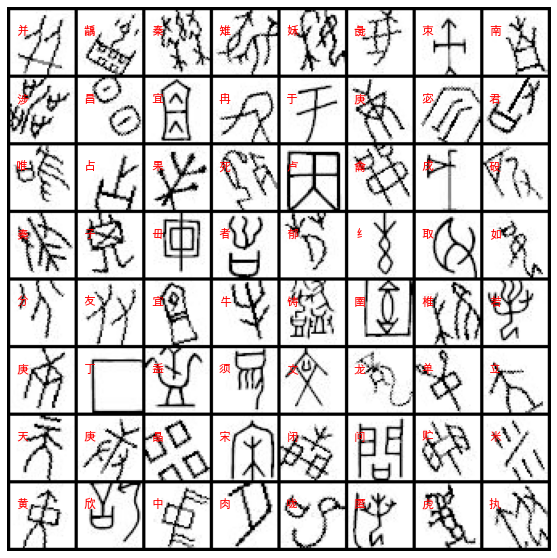

In [128]:
dataloader = DataLoader(transformed_dataset, batch_size=64,
                        shuffle=True, num_workers=0) # change the num_workers = 0 (instead of 4)

# Helper function to show a batch
def show_oracle_character(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, label_batch, name_batch = \
            sample_batched['image'], sample_batched['label'], sample_batched['name']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        # make_grid default padding is 2 so we add it to avoid occlusion of labels.
        plt.text((i%8) * (im_size+2)+5,  ( i // 8) * (im_size+2)+5+12, name_batch[i], 
                fontsize = 12, color='r')

    # for i in range(batch_size):
    #     # plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
    #     #             landmarks_batch[i, :, 1].numpy(),
    #     #             s=10, marker='.', c='r')

    #     plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # observe 4th batch and stop.
    # if i_batch == 3:
    plt.figure(figsize=(10, 10))
    show_oracle_character(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
    if i_batch == 0:
        break                        